# Projection Experiment

## imports and misc

In [1]:
import logging
import os
import sys
import warnings
from time import perf_counter
def append_path(s):
    if s in sys.path:
        return
    sys.path.append(s)
    
#You don’t need those lines if you installed the packages
append_path("/home/tristan/research/ot_markov_distances/")
append_path("/home/tristan/research/tb_ml/")
append_path("/home/tristan/research/FGW/lib")

logging.basicConfig(level=logging.INFO, force=True)

In [2]:
from IPython.display import Video
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation as mpl_animation
import seaborn as sns
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange


In [3]:
from ot_markov_distances import wl_reg_infty
from ot_markov_distances.utils import weighted_transition_matrix, draw_markov
from utils.modules import ParametricMarkovMatrixWithMatchings
from utils.data_generation import circle_graph

%load_ext autoreload
%autoreload 2

In [4]:
logging.basicConfig(level=logging.WARNING, force=True)

## Data

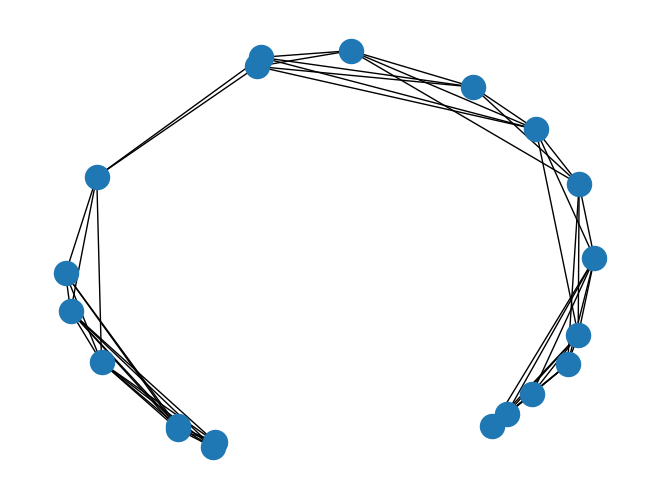

In [5]:
target_size=20
target_graph = circle_graph(target_size)
nx.draw(target_graph, pos=nx.get_node_attributes(target_graph, "pos"))
original_positions = np.asarray(list(nx.get_node_attributes(target_graph, "pos").values()))
target_matrix = weighted_transition_matrix(target_graph, q=.1)

## Optimization loop

In [6]:
### 

  0%|          | 0/300 [00:00<?, ?it/s]

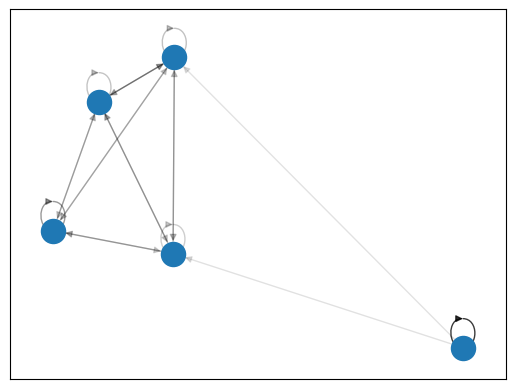

In [10]:
def opt_loop(target_matrix, n_steps=300, projection_size=5, run_name="projection", 
            device = torch.device("cuda:3"), 
             lr=2e-2, 
             weight_decay=1e-4,
             heat=1.,
             matching_heat=1.,
             wl_parameters = dict(delta=.5, sinkhorn_reg=.05, sinkhorn_iter=10, sinkhorn_iter_scheduler="cosine"),
             momentum = 0.,
             matching_type = "rows"
            ):
    
    target_size, _ = target_matrix.shape
    target_matrix = target_matrix.to(device)
    projection = ParametricMarkovMatrixWithMatchings(projection_size, 
                                                     target_size, heat=heat,
                                                    matching_heat=matching_heat,
                                                    matching_type=matching_type).to(device)

    target_measure = torch.ones(target_size, device=device, requires_grad=False) / target_size
    projection_measure = torch.ones(projection_size, device=device, requires_grad=False) / projection_size

    if momentum:
        optim = torch.optim.SGD(projection.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=False)
    else:
        optim = torch.optim.Adam(projection.parameters(), lr=lr, weight_decay=weight_decay)

    writer = SummaryWriter(f"{os.environ['HOME']}/tensorboard/{run_name}")
    parameter_values = []
    losses = []

    for step in trange(n_steps):
        optim.zero_grad()

        M, D = projection()
        loss = wl_reg_infty(M[None, ...], target_matrix[None, ...], 
                            D[None, ...], 
                            muX=projection_measure[None, ...],
                            muY=target_measure[None, ...],
                            **wl_parameters)
        loss.backward()
        optim.step()


        writer.add_scalar("loss", loss, step) 
        losses.append(loss.item())
        with torch.no_grad():
            markov, matching = projection.get()
            parameter_values.append((markov.detach().cpu(), matching.detach().cpu()))
            
    return projection, parameter_values, losses

projection, parameter_values, losses = opt_loop(target_matrix, projection_size=5,
    heat=1/5,
    run_name=f"projection5 - {(run_number:=vars().get('run_number', 0)+1)}")
projection.draw(original_positions)

<AxesSubplot:>

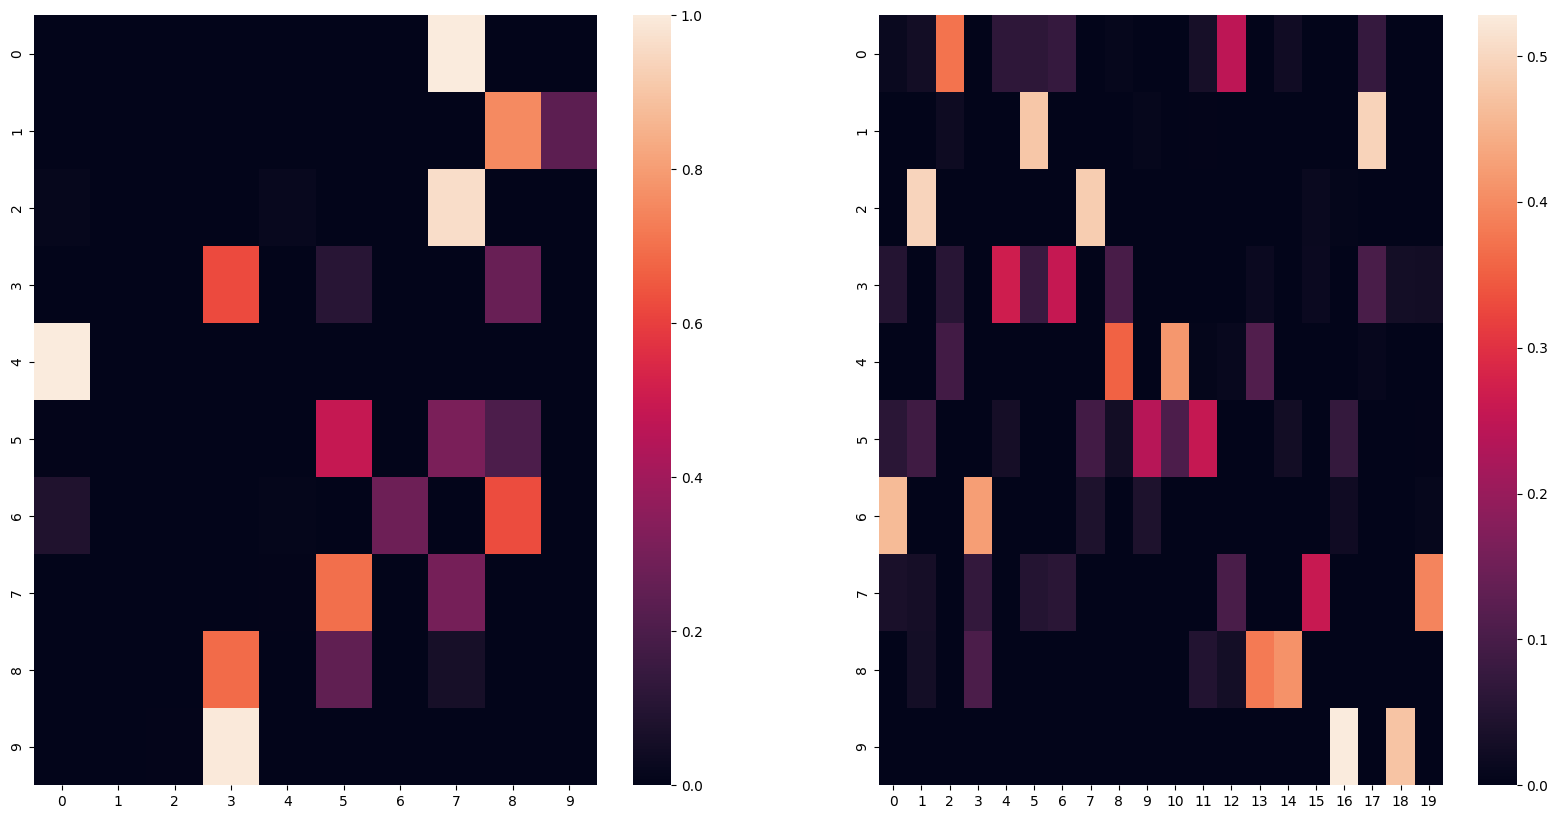

In [20]:
last_markov, last_matching = parameter_values[-1]
_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(last_markov, ax=axes[0])
sns.heatmap(last_matching, ax=axes[1])

### Circle size 10

  0%|          | 0/1000 [00:00<?, ?it/s]

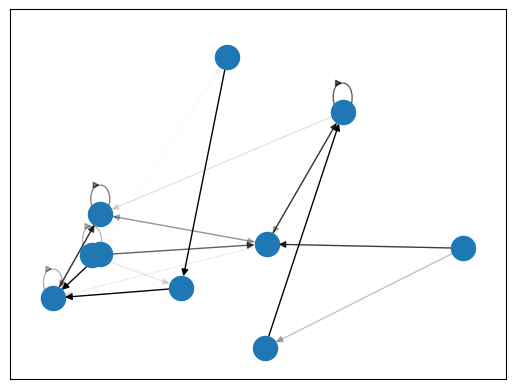

In [17]:
projection, parameter_values, losses = opt_loop(target_matrix, projection_size=10,
    n_steps=1000,
    lr=1e-3,
    weight_decay=0,
    heat=1/20,
    matching_heat=1/30,
    wl_parameters = dict(delta=.5, sinkhorn_reg=.1, sinkhorn_iter=10, sinkhorn_iter_scheduler="cosine"),
    run_name=f"projection10 - {(run_number10:=vars().get('run_number10', 0)+1)}")

projection.draw(original_positions= original_positions)

<AxesSubplot:>

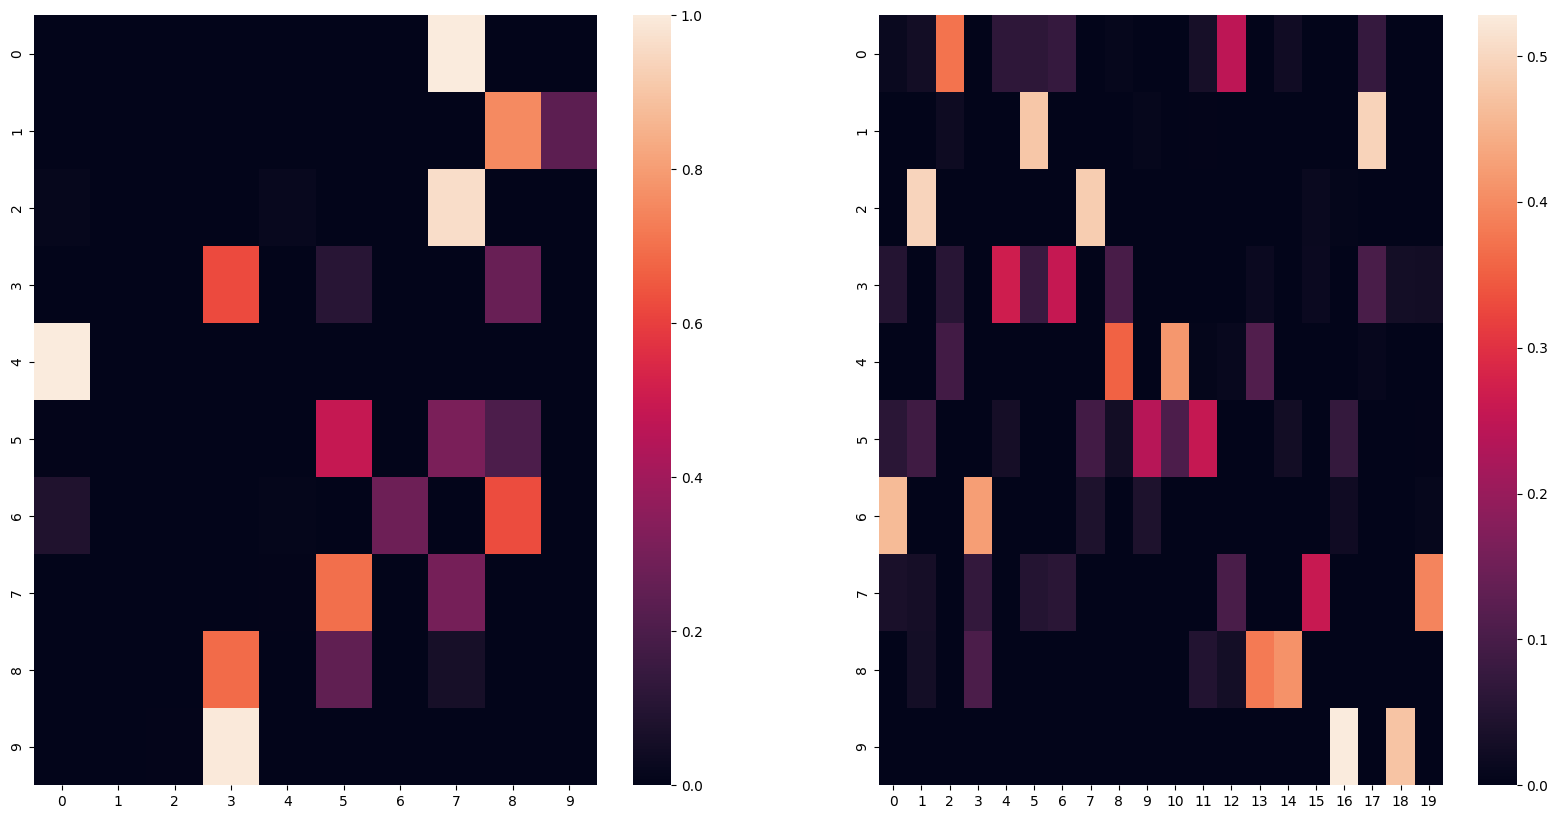

In [18]:
last_markov, last_matching = parameter_values[-1]
_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(last_markov, ax=axes[0])
sns.heatmap(last_matching, ax=axes[1])

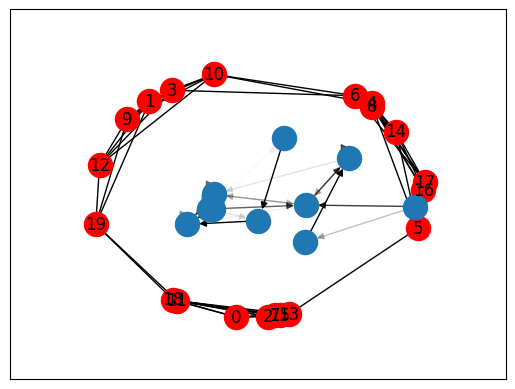

In [19]:

fig = plt.figure()
axis = plt.gca()
interval = 1
def animation(t):
    t = t * interval
    markov, matching = parameter_values[t]
    positions = np.einsum("mi,id->md",matching.numpy(force=True), original_positions) 
    axis.clear()
    nx.draw_networkx(target_graph,  nx.get_node_attributes(target_graph, "pos"), ax=axis, node_color="red")
    draw_markov(markov, {i: p for i, p in enumerate(positions)})
    axis.set_xlim(-1.5, 1.5)
    axis.set_ylim(-1.5, 1.5)



anim = mpl_animation.FuncAnimation(fig, animation, frames=len(parameter_values) // interval, interval=50, blit=False)
anim.save("/tmp/animation7.mp4")
Video("/tmp/animation7.mp4", embed=True)

## Grid

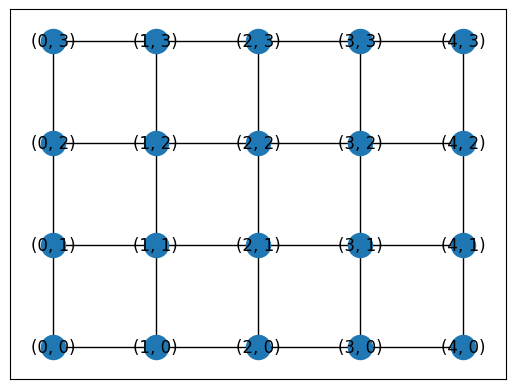

In [11]:
grid_graph = nx.grid_graph((4, 5))
original_pos_grid = np.asarray((*grid_graph.nodes,))
original_grid_positions = np.stack(original_pos_grid).astype(np.float32)
original_grid_positions
nx.draw_networkx(grid_graph, {n: n for n in grid_graph.nodes})

In [ ]:
grid_matrix = weighted_transition_matrix(grid_graph, q=.1)
projection, parameter_values, losses = opt_loop(grid_matrix, projection_size=10,
    n_steps=10000,
    lr=1,
    weight_decay=0,
    heat=1.,
    matching_heat=1.,
    wl_parameters = dict(delta=.2, sinkhorn_reg=.01, sinkhorn_iter=15, sinkhorn_iter_scheduler="cosine"),
    run_name=f"projection_grid - {(run_numbergrid:=vars().get('run_numbergrid', 0)+1)}",
    momentum=.5,
    matching_type="full")

nx.draw(grid_graph, {n: n for n in grid_graph.nodes}, node_color="red")
projection.draw(original_grid_positions)

  0%|          | 0/10000 [00:00<?, ?it/s]

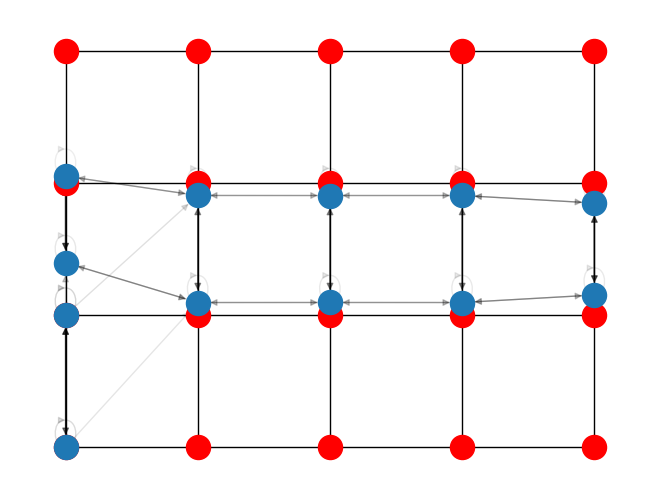

In [49]:
nx.draw(grid_graph, {n: n for n in grid_graph.nodes}, node_color="red")
projection.draw(original_grid_positions)


<AxesSubplot:>

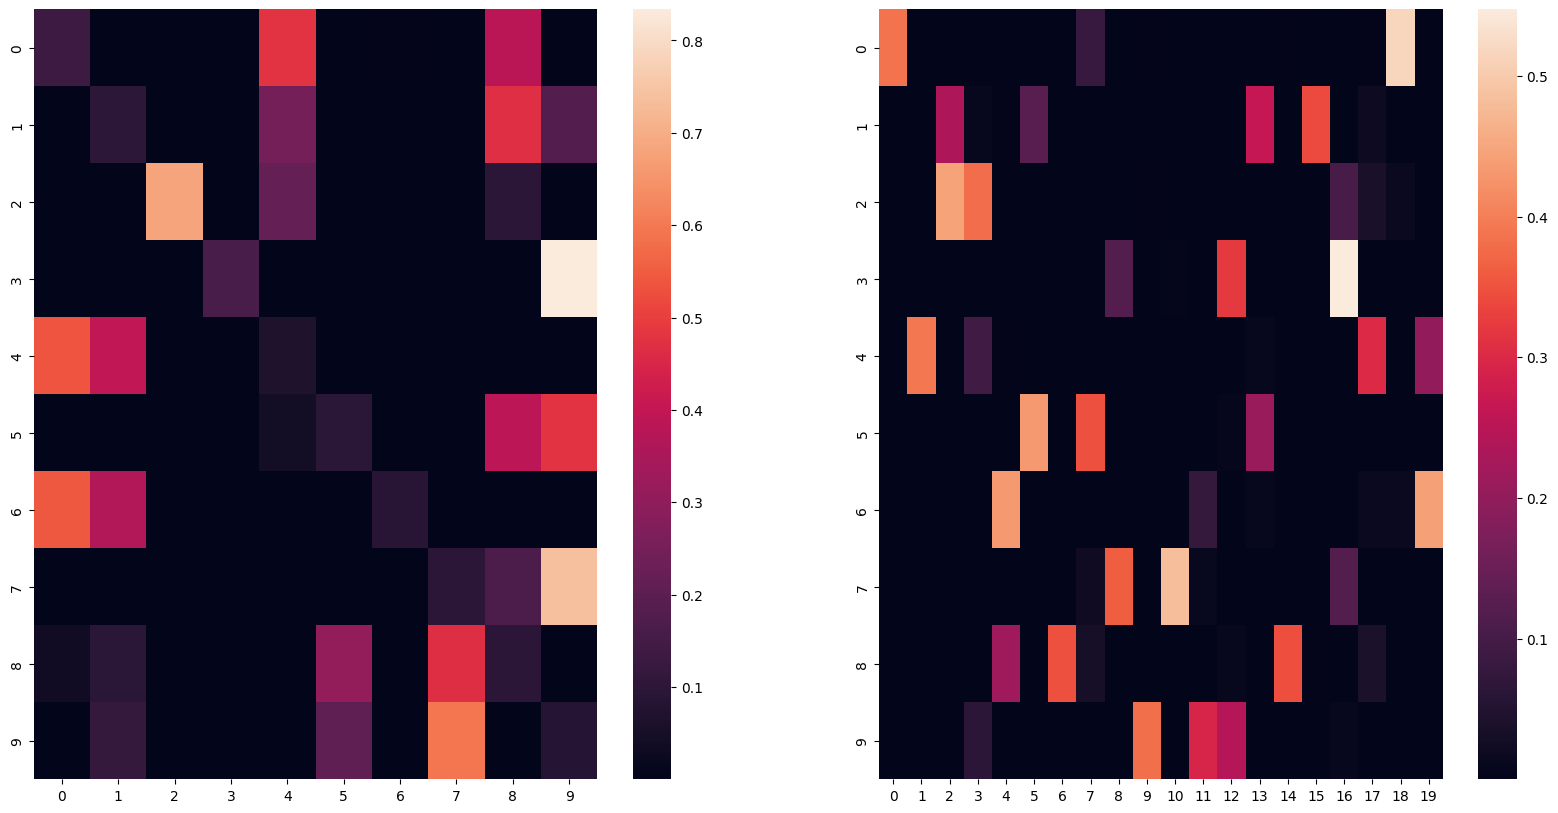

In [102]:
markov, matching = projection.get()
_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(markov.numpy(force=True), ax=axes[0])
sns.heatmap(matching.numpy(force=True), ax=axes[1])

In [ ]:

fig = plt.figure()
axis = plt.gca()
interval = 5
def animation(t):
    t = t * interval
    markov, matching = parameter_values[t]
    positions = np.einsum("mi,id->md",matching.numpy(force=True), original_grid_positions) 
    axis.clear()
    nx.draw(grid_graph,  {n: n for n in grid_graph.nodes}, node_color="red")
    draw_markov(markov, {i: p for i, p in enumerate(positions)})


anim = mpl_animation.FuncAnimation(fig, animation, frames=len(parameter_values) // interval, interval=50, blit=False)
anim.save("/tmp/animation7.mp4")
Video("/tmp/animation7.mp4", embed=True)